In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import pandas as pd
import sqlite3
import rubin_sim
import rubin_sim.maf as maf
from rubin_sim.scheduler.utils import SkyAreaGenerator
from rubin_sim.data import get_baseline
rubin_sim.__version__

'1.3.2'

In [2]:
from os import path

opsim_fname = rubin_sim.data.get_baseline()
run_name = path.splitext(path.basename(opsim_fname))[0]
print(f"Using {run_name}, to be read from {opsim_fname}")
# opsim_fname is being pulled from a rubin_sim command - Heather is going to update this.

Using baseline_v2.1_10yrs, to be read from /global/cfs/cdirs/lsst/groups/CO/rubin_sim/sim_baseline/baseline_v2.1_10yrs.db


In [3]:
# Routines to do stuff with maps - so we can make a survey mask.
def load_maf_map(fname):
    
    fin = maf.MetricBundle(
        metric=maf.ExgalM5(),
        slicer=maf.HealpixSubsetSlicer(nside=nside, use_cache=False, hpid=np.where(map_labels == "lowdust")[0]),
        constraint='note not like "DD%" and note not like "twilight_neo"'
    )
    fin._setup_metric_values()
    #counts/map values
    opmap=fin.metric_values
    mafmap=np.copy(opmap.data)
    mafmap[opmap.mask]=0
    mafmap[mafmap>0]=1
    
    return mafmap

def maf_maps_to_fits(fname_in):
    usemap = load_maf_map(fname_in)
    # save this into fits file:
    fname = './map_for_paul.fits'
    hp.write_map(fname, usemap, overwrite=True)
    print("Written: %s"%fname)
    

In [4]:
# Write a map for Paul based on v3.3
fname_for_paul = "/pscratch/sd/r/rhlozek/rubin_sim_data/sim_baseline/baseline_v3.3_10yrs.db"
#maf_maps_to_fits(fname_for_paul)

In [5]:
# Make sure it looks OK.
#test_map = hp.read_map('map_for_paul.fits')
#print(np.min(test_map), np.max(test_map))
#hp.mollview(test_map)

In [6]:
# Plot wish-list:
# After cutting to extragalactic WFD area (approx done), we want the following:
#   - Distribution of i-band coadd M5 values at each data release from year 1 - year 10 (DR2-DR11)... so far just year 10
#   - Later we want all bands, not just i
# We want to be able to compare across different axes:
#   - For a given strategy, compare distributions at various years -> Renee working on this.
#   - For a given year, compare distributions across strategies -> integrate Renee's development from before
#   - for a given year and strategy, compare distributions across bands.
# Then take the RMS values and use Arun's stuff to turn them into RMS <z>.
# Figure out how to connect with the Delta delta group.
# Incorporated combined depth from Matt once he has it

## Let's start with a simple metric bundle of only the ExgalM5 metric
Remember that the list of metrics is here: https://rubin-sim.lsst.io/rs_maf/metric_list.html

In [41]:
# Here we define a function for some of the metric plots we want to show.
# TODO: allow customization of metric resolution, results for intermediate years.
# Can use plot_funcs kwarg in metric_plots to change what is plotted.
# Check varying `nside` once we can load dust maps
nside=64
surveyAreas = SkyAreaGenerator(nside=nside)
map_footprints, map_labels = surveyAreas.return_maps()
def metric_plots(use_run_name, use_opsim_fname, use_metric=maf.ExgalM5(), use_color_min=None, use_color_max=None,
                year=10):
    # use_run_name says which OpSim DB we want to use, e.g. `baseline_v2.1_10yrs` - will also be used for labels
    # use_opsim_fname says where it lives, e.g. `/global/cfs/cdirs/lsst/groups/CO/rubin_sim/sim_baseline/baseline_v2.1_10yrs.db`
    days = year*365.3
    constraint_str='filter="i" and note not like "DD%" and night <= XX and note not like "twilight_neo" '
    constraint_str = constraint_str.replace('XX','%d'%days)
    if use_color_min is not None and use_color_max is not None:
        plot_dict={"color_min": use_color_min, "color_max": use_color_max, "x_min": use_color_min, "x_max": use_color_max}
    else:
        plot_dict=None
    depth_map_bundle = maf.MetricBundle(
        metric=use_metric,
        # previous line was originally using maf.Coaddm5Metric()
        slicer=maf.HealpixSubsetSlicer(nside=nside, use_cache=False, hpid=np.where(map_labels == "lowdust")[0]),
        #slicer=maf.HealpixSlicer(nside=nside, use_cache=False),
        # Above has changed to avoid high dust regions
        constraint=constraint_str,
        # Reject certain types of observations
        run_name=use_run_name,
        summary_metrics=[maf.MedianMetric(), maf.MeanMetric(), maf.RmsMetric(), maf.PercentileMetric(percentile=25), maf.PercentileMetric(percentile=75)],
        plot_dict=plot_dict
    )
    #print('Bundle diagnostics',depth_map_bundle.run_name, depth_map_bundle.metric.name, 
    #    depth_map_bundle.info_label, depth_map_bundle.slicer.slicer_name)
    
    bd = maf.metricBundles.make_bundles_dict_from_list([depth_map_bundle])
    bgroup = maf.MetricBundleGroup(
        bd, use_opsim_fname
    )
    bgroup.run_all()
    
    return bgroup, bd

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


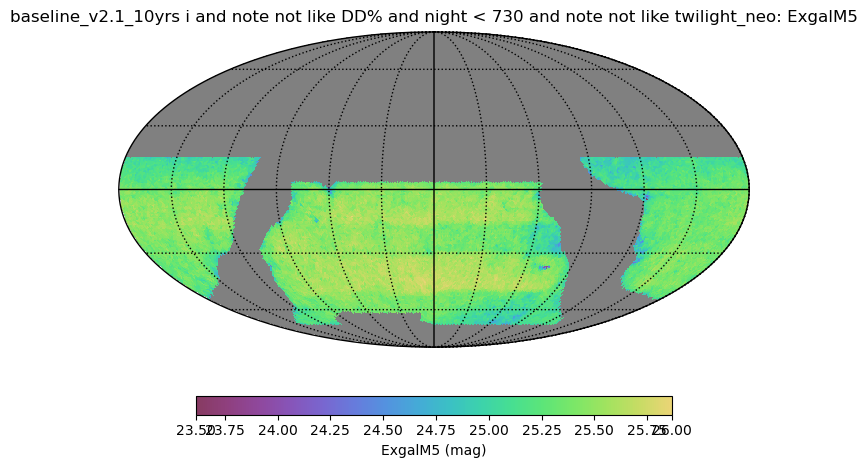

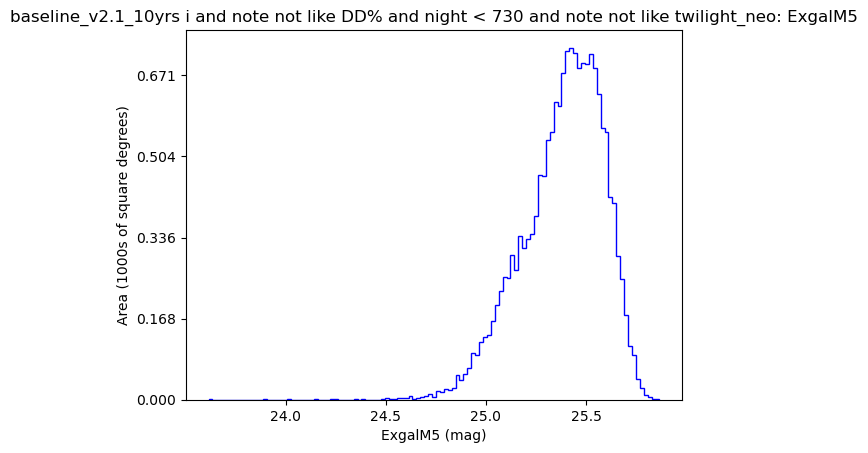

In [42]:
# Apply the above routine to our baseline sim, and show the plots
bgroup, bd = metric_plots(run_name, opsim_fname, year=2)
bgroup.plot_all(closefigs=False)

In [44]:
pd.DataFrame([bd[k].summary_values for k in bd], index=list(bd.keys()))

,Median,Mean,Rms,25th%ile,75th%ile
baseline_v2_1_10yrs_ExgalM5_i_and_note_not_like_DD_and_night_lt_730_and_note_not_like_twilight_neo_HEAL,25.409858,25.381524,0.200743,25.261927,25.530783


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


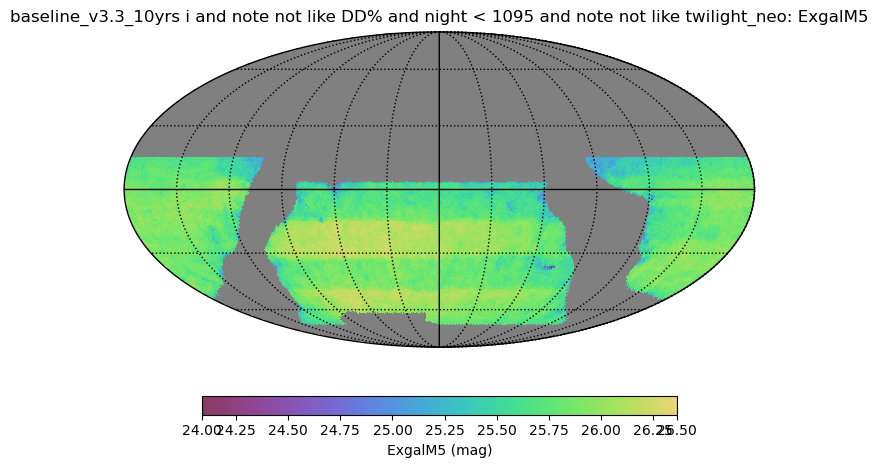

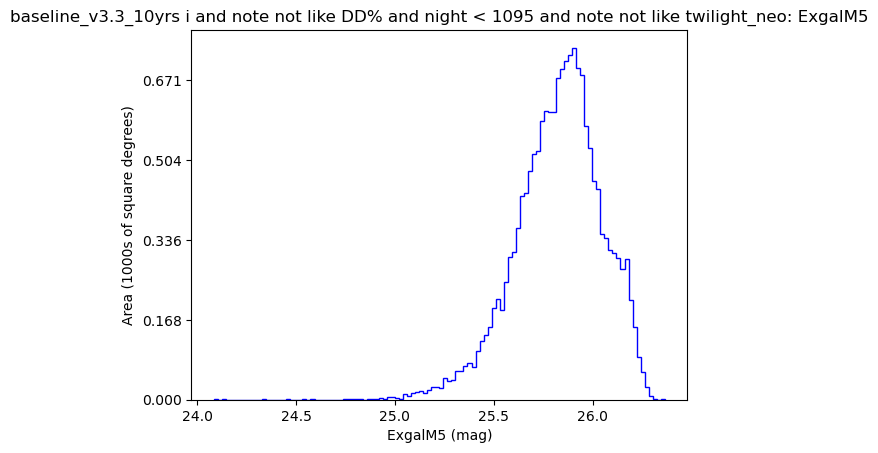

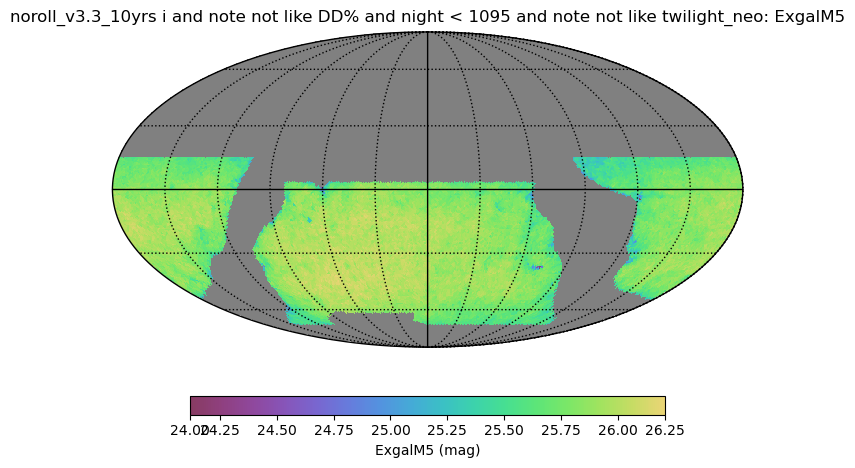

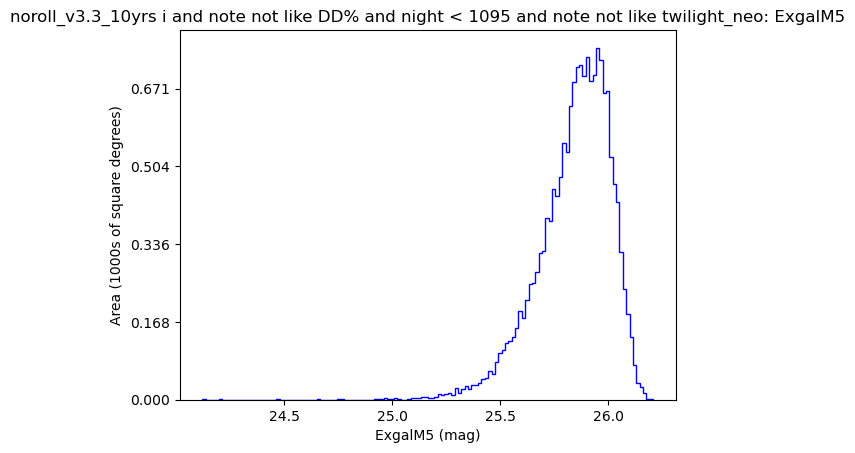

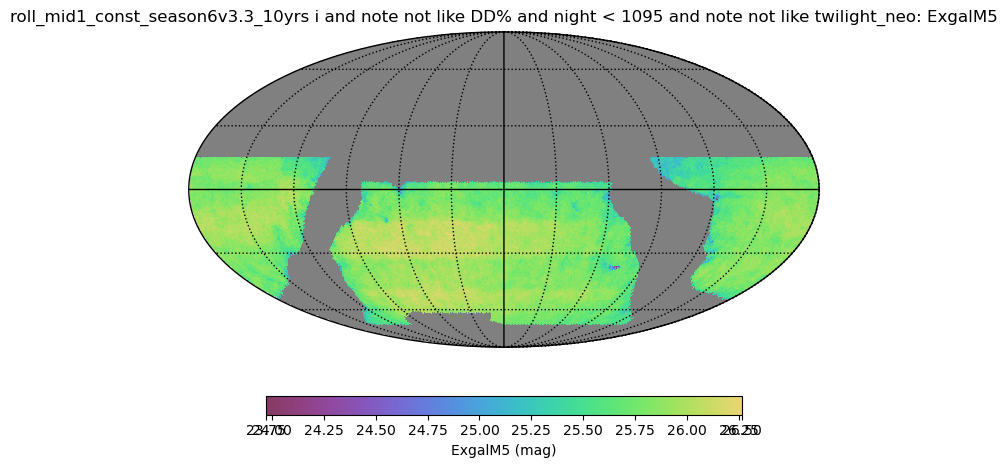

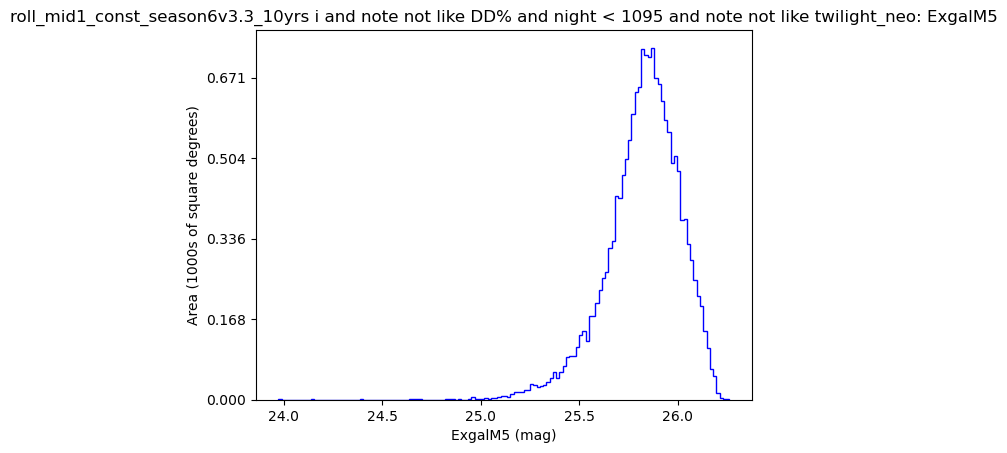

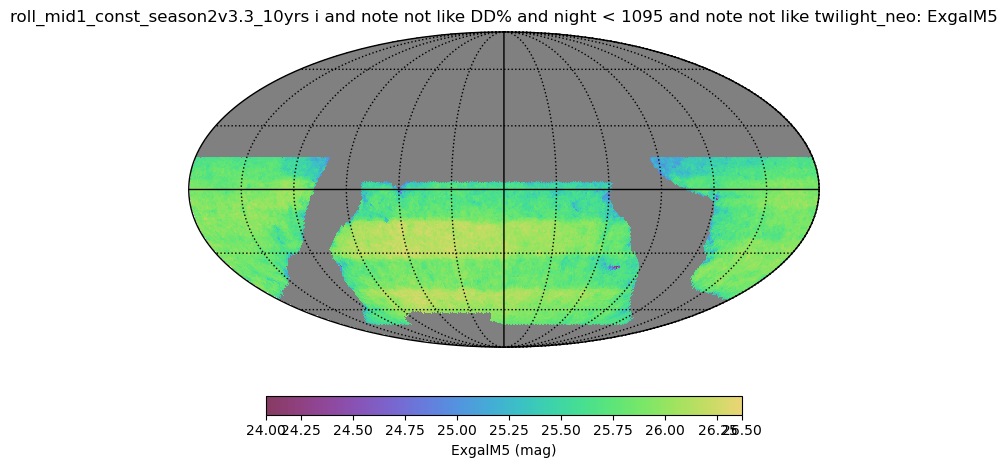

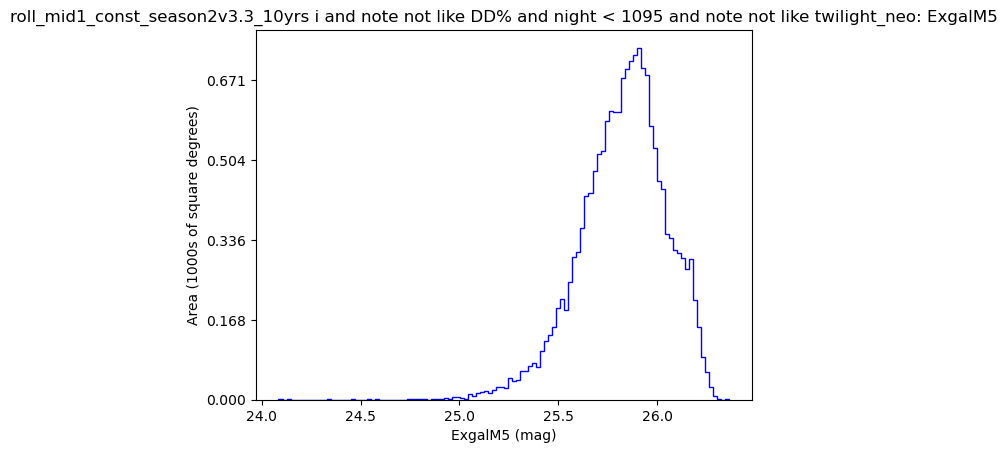

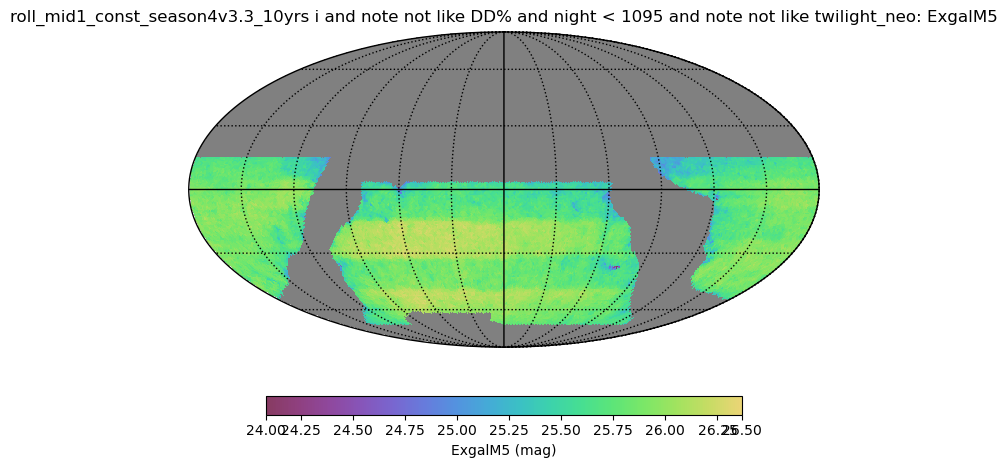

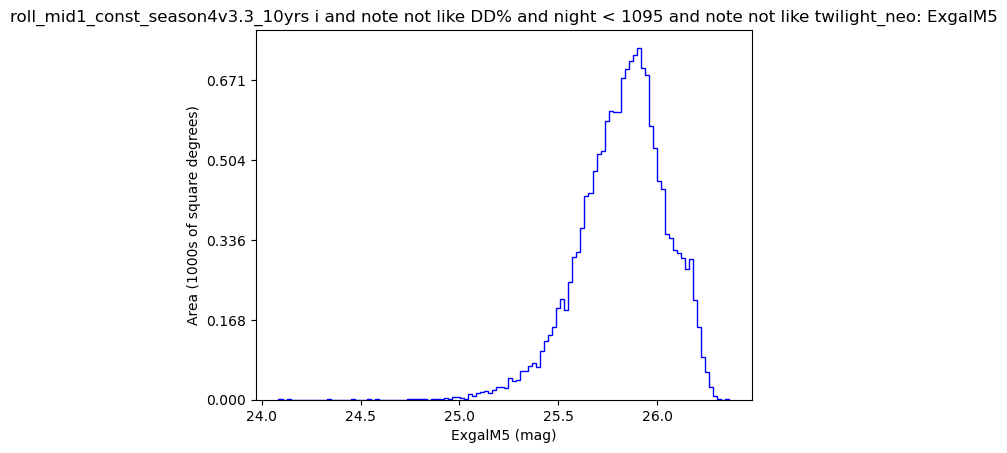

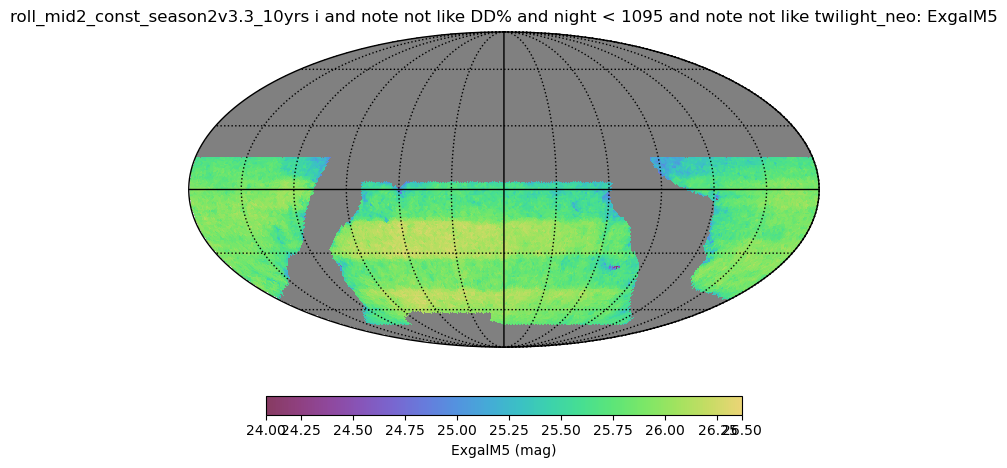

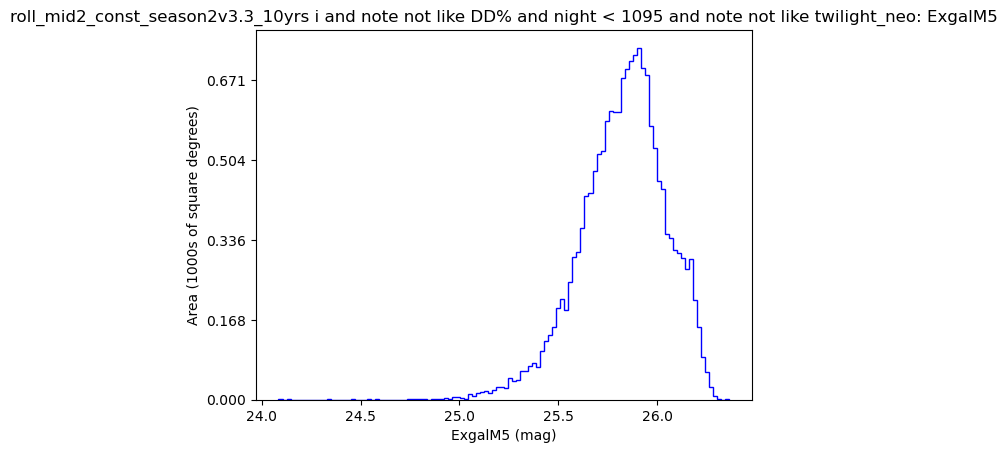

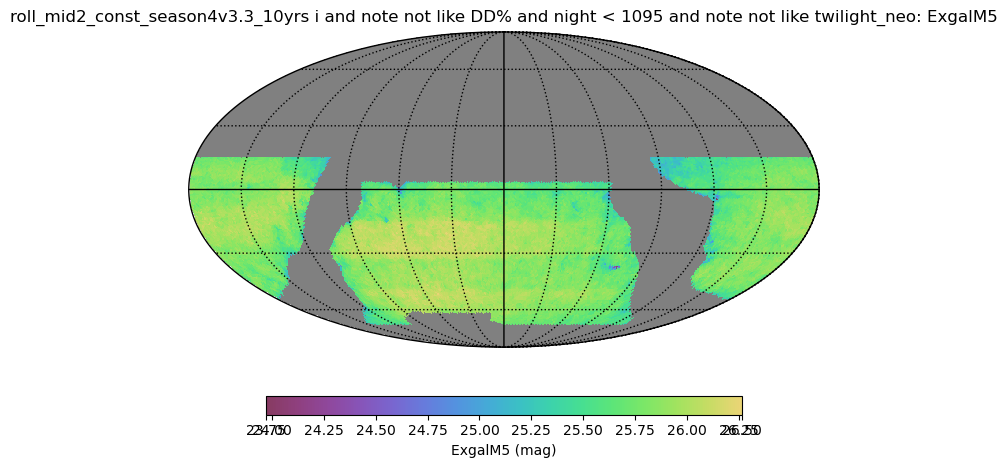

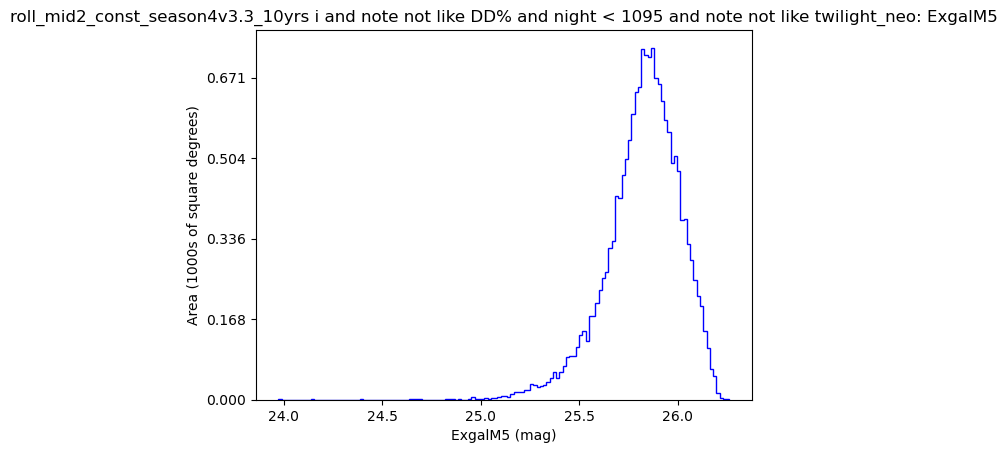

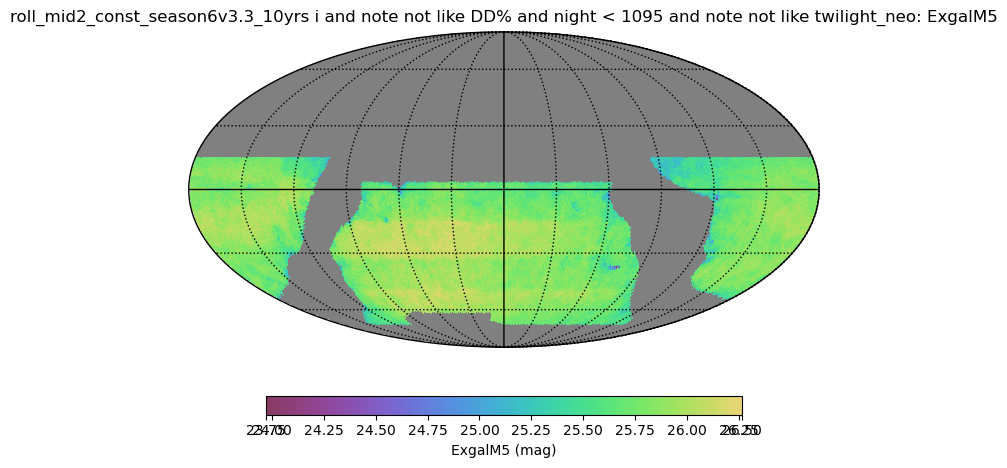

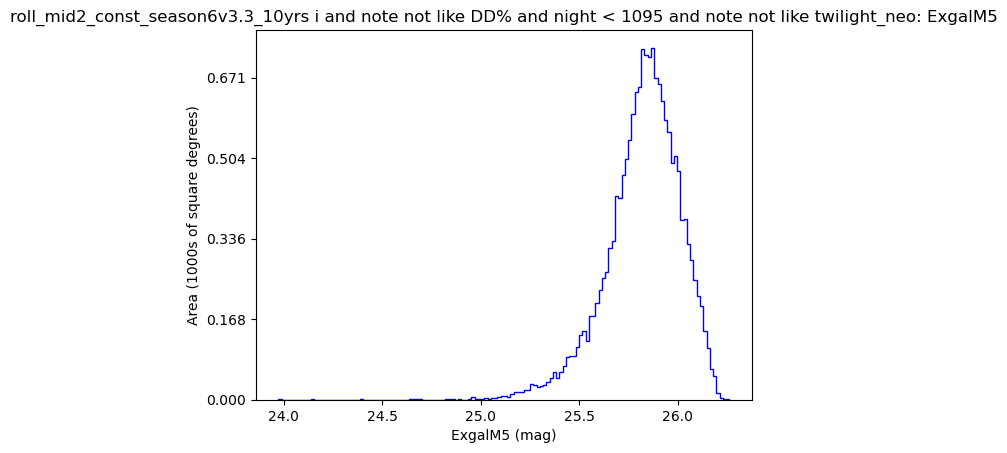

In [58]:
sim_list = ['/pscratch/sd/r/rhlozek/rubin_sim_data/sim_baseline/baseline_v3.3_10yrs.db',
           '/pscratch/sd/r/rhlozek/rubin_sim_data/noroll/noroll_v3.3_10yrs.db',
           '/pscratch/sd/r/rhlozek/rubin_sim_data/noroll/roll_mid1_const_season6v3.3_10yrs.db',
           '/pscratch/sd/r/rhlozek/rubin_sim_data/noroll/roll_mid1_const_season2v3.3_10yrs.db',
           '/pscratch/sd/r/rhlozek/rubin_sim_data/noroll/roll_mid1_const_season4v3.3_10yrs.db',
           '/pscratch/sd/r/rhlozek/rubin_sim_data/noroll/roll_mid2_const_season2v3.3_10yrs.db',
           '/pscratch/sd/r/rhlozek/rubin_sim_data/noroll/roll_mid2_const_season4v3.3_10yrs.db',
           '/pscratch/sd/r/rhlozek/rubin_sim_data/noroll/roll_mid2_const_season6v3.3_10yrs.db',]
name_list = [path.splitext(path.basename(sim))[0] for sim in sim_list]
for i in range(len(sim_list)):
    this_run = sim_list[i]
    this_fname = name_list[i]
    bgroup, bd = metric_plots(this_fname, this_run, year=3)
    bgroup.plot_all(closefigs=False)

In [45]:
sim_list = ['/pscratch/sd/r/rhlozek/rubin_sim_data/sim_baseline/baseline_v3.3_10yrs.db',
           '/pscratch/sd/r/rhlozek/rubin_sim_data/noroll/noroll_v3.3_10yrs.db',
           '/pscratch/sd/r/rhlozek/rubin_sim_data/noroll/roll_mid1_const_season2v3.3_10yrs.db',
           '/pscratch/sd/r/rhlozek/rubin_sim_data/noroll/roll_mid1_const_season4v3.3_10yrs.db',
           '/pscratch/sd/r/rhlozek/rubin_sim_data/noroll/roll_mid1_const_season6v3.3_10yrs.db',
           '/pscratch/sd/r/rhlozek/rubin_sim_data/noroll/roll_mid2_const_season2v3.3_10yrs.db',
           '/pscratch/sd/r/rhlozek/rubin_sim_data/noroll/roll_mid2_const_season4v3.3_10yrs.db',
           '/pscratch/sd/r/rhlozek/rubin_sim_data/noroll/roll_mid2_const_season6v3.3_10yrs.db',]
name_list = [path.splitext(path.basename(sim))[0] for sim in sim_list]
year_list = np.arange(1,11)
#print(sim_list)
#print(name_list)
#print(year_list)
overall_names = []
overall_years = []
overall_meds = []
overall_means = []
overall_std = []
overall_iqr = []
for year in year_list:
    for i in range(len(sim_list)):
        bgroup, bd = metric_plots(name_list[i], sim_list[i], year=year)
        print(sim_list[i], name_list[i], year, bd[list(bd.keys())[0]].summary_values)
        overall_names.append(name_list[i])
        overall_years.append(year)
        overall_meds.append(bd[list(bd.keys())[0]].summary_values['Median'])
        overall_means.append(bd[list(bd.keys())[0]].summary_values['Mean'])
        overall_std.append(bd[list(bd.keys())[0]].summary_values['Rms'])
        overall_iqr.append(bd[list(bd.keys())[0]].summary_values['75th%ile']-bd[list(bd.keys())[0]].summary_values['25th%ile'])
df = pd.DataFrame(list(zip(overall_names, overall_years, overall_meds, overall_means, overall_std, overall_iqr)), 
                  columns=['Strategy', 'Year', 'Median i-band depth', 'Mean i-band depth', 'Std i-band depth', 'IQR i-band depth'])
display(df)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


/pscratch/sd/r/rhlozek/rubin_sim_data/sim_baseline/baseline_v3.3_10yrs.db baseline_v3.3_10yrs 1 {'Median': 25.252161370058857, 'Mean': 25.233240383873905, 'Rms': 0.184610448906923, '25th%ile': 25.126502840900024, '75th%ile': 25.362450354577}
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
/pscratch/sd/r/rhlozek/rubin_sim_data/noroll/noroll_v3.3_10yrs.db noroll_v3.3_10yrs 1 {'Median': 25.252161370058857, 'Mean': 25.233240383873905, 'Rms': 0.184610448906923, '25th%ile': 25.126502840900024, '75th%ile': 25.362450354577}
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
/pscratch/sd/r/rhlozek/rubin_sim_data/noroll/roll_mid1_const_season2v3.3_10yrs.db roll_mid1_const_season2v3.3_10yrs 1 {'Median': 25.252161370058857, 'Mean': 25.233240383873905, 'Rms': 0.184610448906923, '25th%ile': 25.126502840900024, '75th%ile': 25.362450354577}
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
/pscratch/sd/r/rhlozek/rubin_sim_data

,Strategy,Year,Median i-band depth,Mean i-band depth,Std i-band depth,IQR i-band depth
0,baseline_v3.3_10yrs,1,25.252161,25.233240,0.184610,0.235948
1,noroll_v3.3_10yrs,1,25.252161,25.233240,0.184610,0.235948
2,roll_mid1_const_season2v3.3_10yrs,1,25.252161,25.233240,0.184610,0.235948
3,roll_mid1_const_season4v3.3_10yrs,1,25.252161,25.233240,0.184610,0.235948
4,roll_mid1_const_season6v3.3_10yrs,1,25.252161,25.233240,0.184610,0.235948
...,...,...,...,...,...,...
75,roll_mid1_const_season4v3.3_10yrs,10,26.395938,26.369284,0.157892,0.198346
76,roll_mid1_const_season6v3.3_10yrs,10,26.391862,26.363840,0.157892,0.196083
77,roll_mid2_const_season2v3.3_10yrs,10,26.408314,26.377038,0.156602,0.194922
78,roll_mid2_const_season4v3.3_10yrs,10,26.396751,26.370429,0.157705,0.195045


In [46]:
df.to_pickle('magic_dataframe.pkl') 


In [20]:
df = pd.read_pickle('magic_dataframe.pkl')

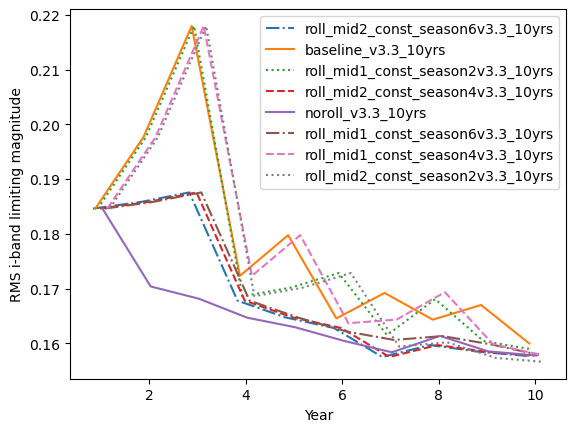

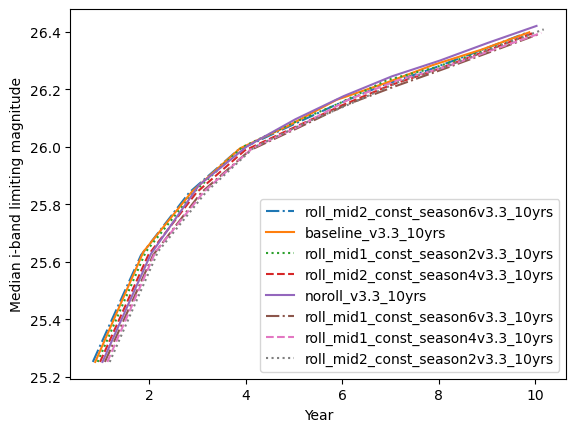

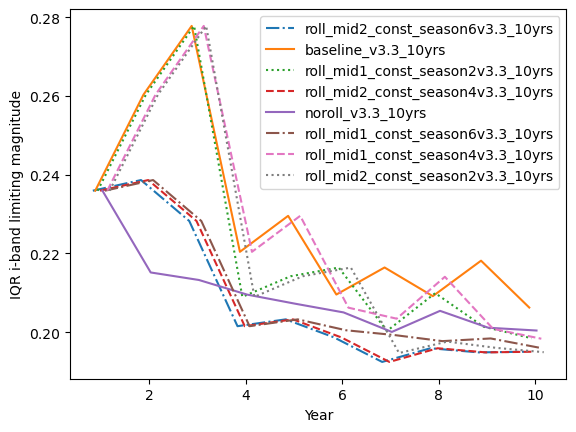

In [53]:
x=np.array(list(set(df['Year'])))
strategies=list(set(df['Strategy']))
fig = plt.figure()
ax = fig.add_subplot(111)
offsets = 0.05*np.arange(0,len(strategies))
offsets -= np.mean(offsets)
offset_index = 0
for s in strategies:
    y1=np.array(df['Std i-band depth'][df['Strategy']==s])
    if 'season2' in s: my_linestyle = 'dotted'
    elif 'season4' in s: my_linestyle = 'dashed'
    elif 'season6' in s: my_linestyle = 'dashdot'
    else: my_linestyle = 'solid'
    ax.plot(x+offsets[offset_index], y1, label=s, linestyle=my_linestyle)
    offset_index += 1
plt.xlabel('Year')
plt.ylabel('RMS i-band limiting magnitude')
plt.legend()
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
offset_index = 0
for s in strategies:
    y2=np.array(df['Median i-band depth'][df['Strategy']==s])
    if 'season2' in s: my_linestyle = 'dotted'
    elif 'season4' in s: my_linestyle = 'dashed'
    elif 'season6' in s: my_linestyle = 'dashdot'
    else: my_linestyle = 'solid'
    ax.plot(x+offsets[offset_index], y2, label=s, linestyle=my_linestyle)
    offset_index += 1
plt.xlabel('Year')
plt.ylabel('Median i-band limiting magnitude')
plt.legend()
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
offset_index = 0
for s in strategies:
    y3=np.array(df['IQR i-band depth'][df['Strategy']==s])
    if 'season2' in s: my_linestyle = 'dotted'
    elif 'season4' in s: my_linestyle = 'dashed'
    elif 'season6' in s: my_linestyle = 'dashdot'
    else: my_linestyle = 'solid'
    ax.plot(x+offsets[offset_index], y3, label=s, linestyle=my_linestyle)
    offset_index += 1
plt.xlabel('Year')
plt.ylabel('IQR i-band limiting magnitude')
plt.legend()
plt.show()

In [60]:
sim_list = ['/pscratch/sd/b/beckermr/v2.2_sims_rubin/baseline_v2.2_10yrs.db',
           '/pscratch/sd/b/beckermr/v2.2_sims_rubin/noroll_v2.2_10yrs.db',
           '/pscratch/sd/b/beckermr/v2.2_sims_rubin/roll_with_const_roll_indx0_v2.2_10yrs.db',
           '/pscratch/sd/b/beckermr/v2.2_sims_rubin/roll_with_const_roll_indx4_v2.2_10yrs.db']
name_list = [path.splitext(path.basename(sim))[0] for sim in sim_list]
year_list = np.arange(1,11)
#print(sim_list)
#print(name_list)
#print(year_list)
overall_names = []
overall_years = []
overall_meds = []
overall_means = []
overall_std = []
overall_iqr = []
for year in year_list:
    for i in range(len(sim_list)):
        bgroup, bd = metric_plots(name_list[i], sim_list[i], year=year)
        print(sim_list[i], name_list[i], year, bd[list(bd.keys())[0]].summary_values)
        overall_names.append(name_list[i])
        overall_years.append(year)
        overall_meds.append(bd[list(bd.keys())[0]].summary_values['Median'])
        overall_means.append(bd[list(bd.keys())[0]].summary_values['Mean'])
        overall_std.append(bd[list(bd.keys())[0]].summary_values['Rms'])
        overall_iqr.append(bd[list(bd.keys())[0]].summary_values['75th%ile']-bd[list(bd.keys())[0]].summary_values['25th%ile'])
df3 = pd.DataFrame(list(zip(overall_names, overall_years, overall_meds, overall_means, overall_std, overall_iqr)), 
                  columns=['Strategy', 'Year', 'Median i-band depth', 'Mean i-band depth', 'Std i-band depth', 'IQR i-band depth'])
display(df3)
df3.to_pickle('magic_dataframe_v2.2.pkl')

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
/pscratch/sd/b/beckermr/v2.2_sims_rubin/baseline_v2.2_10yrs.db baseline_v2.2_10yrs 1 {'Median': 25.16025451471503, 'Mean': 25.136473131891073, 'Rms': 0.19082274952532557, '25th%ile': 25.03047334976938, '75th%ile': 25.270334711834273}
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
/pscratch/sd/b/beckermr/v2.2_sims_rubin/noroll_v2.2_10yrs.db noroll_v2.2_10yrs 1 {'Median': 25.16025451471503, 'Mean': 25.136473131891073, 'Rms': 0.19082274952532557, '25th%ile': 25.03047334976938, '75th%ile': 25.270334711834273}
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
/pscratch/sd/b/beckermr/v2.2_sims_rubin/roll_with_const_roll_indx0_v2.2_10yrs.db roll_with_const_roll_indx0_v2.2_10yrs 1 {'Median': 25.16025451471503, 'Mean': 25.136473131891073, 'Rms': 0.19082274952532557, '25th%ile': 25.03047334976938, '75th%ile': 25.270334711834273}
Healpix slicer using NSIDE=64, approximat

,Strategy,Year,Median i-band depth,Mean i-band depth,Std i-band depth,IQR i-band depth
0,baseline_v2.2_10yrs,1,25.160255,25.136473,0.190823,0.239861
1,noroll_v2.2_10yrs,1,25.160255,25.136473,0.190823,0.239861
2,roll_with_const_roll_indx0_v2.2_10yrs,1,25.160255,25.136473,0.190823,0.239861
3,roll_with_const_roll_indx4_v2.2_10yrs,1,25.167899,25.111337,0.286710,0.346022
4,baseline_v2.2_10yrs,2,25.454345,25.432125,0.203050,0.279260
5,noroll_v2.2_10yrs,2,25.455127,25.427976,0.182507,0.244293
6,roll_with_const_roll_indx0_v2.2_10yrs,2,25.454345,25.432125,0.203050,0.279260
7,roll_with_const_roll_indx4_v2.2_10yrs,2,25.431124,25.421160,0.238444,0.336054
8,baseline_v2.2_10yrs,3,25.667793,25.667808,0.211541,0.279279
9,noroll_v2.2_10yrs,3,25.707285,25.677149,0.168689,0.214173


In [54]:
sim_list = ['/pscratch/sd/r/rhlozek/rubin_sim_data/sim_baseline/baseline_v3.3_10yrs.db',
           '/pscratch/sd/r/rhlozek/rubin_sim_data/noroll/noroll_v3.3_10yrs.db',
           '/pscratch/sd/r/rhlozek/rubin_sim_data/noroll/roll_mid1_const_season2v3.3_10yrs.db',
           '/pscratch/sd/r/rhlozek/rubin_sim_data/noroll/roll_mid1_const_season4v3.3_10yrs.db',
           '/pscratch/sd/r/rhlozek/rubin_sim_data/noroll/roll_mid1_const_season6v3.3_10yrs.db',
           '/pscratch/sd/r/rhlozek/rubin_sim_data/noroll/roll_mid2_const_season2v3.3_10yrs.db',
           '/pscratch/sd/r/rhlozek/rubin_sim_data/noroll/roll_mid2_const_season4v3.3_10yrs.db',
           '/pscratch/sd/r/rhlozek/rubin_sim_data/noroll/roll_mid2_const_season6v3.3_10yrs.db',]
name_list = [path.splitext(path.basename(sim))[0] for sim in sim_list]
year_list = np.arange(1,11)
#print(sim_list)
#print(name_list)
#print(year_list)
overall_names = []
overall_years = []
overall_meds = []
overall_means = []
overall_std = []
overall_iqr = []
for year in year_list:
    for i in range(len(sim_list)):
        bgroup, bd = metric_plots(name_list[i], sim_list[i], use_metric=maf.RIZDetectionCoaddExposureTime(), year=year)
        print(sim_list[i], name_list[i], year, bd[list(bd.keys())[0]].summary_values)
        overall_names.append(name_list[i])
        overall_years.append(year)
        overall_meds.append(bd[list(bd.keys())[0]].summary_values['Median'])
        overall_means.append(bd[list(bd.keys())[0]].summary_values['Mean'])
        overall_std.append(bd[list(bd.keys())[0]].summary_values['Rms'])
        overall_iqr.append(bd[list(bd.keys())[0]].summary_values['75th%ile']-bd[list(bd.keys())[0]].summary_values['25th%ile'])
df = pd.DataFrame(list(zip(overall_names, overall_years, overall_meds, overall_means, overall_std, overall_iqr)), 
                  columns=['Strategy', 'Year', 'Median i-band depth', 'Mean i-band depth', 'Std i-band depth', 'IQR i-band depth'])

df2 = pd.DataFrame(list(zip(overall_names, overall_years, overall_meds, overall_means, overall_std, overall_iqr)), 
                  columns=['Strategy', 'Year', 'Median RIZ exposure time', 'Mean RIZ exposure time', 'Std RIZ exposure time', 'IQR RIZ exposure time'])
display(df2)
df2.to_pickle('magic_dataframe2.pkl') 

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


/pscratch/sd/r/rhlozek/rubin_sim_data/sim_baseline/baseline_v3.3_10yrs.db baseline_v3.3_10yrs 1 {'Median': 600.0, 'Mean': 584.8494437577256, 'Rms': 90.5787917002157, '25th%ile': 510.0, '75th%ile': 660.0}
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
/pscratch/sd/r/rhlozek/rubin_sim_data/noroll/noroll_v3.3_10yrs.db noroll_v3.3_10yrs 1 {'Median': 600.0, 'Mean': 584.8494437577256, 'Rms': 90.5787917002157, '25th%ile': 510.0, '75th%ile': 660.0}
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
/pscratch/sd/r/rhlozek/rubin_sim_data/noroll/roll_mid1_const_season2v3.3_10yrs.db roll_mid1_const_season2v3.3_10yrs 1 {'Median': 600.0, 'Mean': 584.8494437577256, 'Rms': 90.5787917002157, '25th%ile': 510.0, '75th%ile': 660.0}
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
/pscratch/sd/r/rhlozek/rubin_sim_data/noroll/roll_mid1_const_season4v3.3_10yrs.db roll_mid1_const_season4v3.3_10yrs 1 {'Median': 600.0, 'Mean': 584.849

,Strategy,Year,Median RIZ exposure time,Mean RIZ exposure time,Std RIZ exposure time,IQR RIZ exposure time
0,baseline_v3.3_10yrs,1,600.0,584.849444,90.578792,150.0
1,noroll_v3.3_10yrs,1,600.0,584.849444,90.578792,150.0
2,roll_mid1_const_season2v3.3_10yrs,1,600.0,584.849444,90.578792,150.0
3,roll_mid1_const_season4v3.3_10yrs,1,600.0,584.849444,90.578792,150.0
4,roll_mid1_const_season6v3.3_10yrs,1,600.0,584.849444,90.578792,150.0
...,...,...,...,...,...,...
75,roll_mid1_const_season4v3.3_10yrs,10,5430.0,5412.906304,274.141029,330.0
76,roll_mid1_const_season6v3.3_10yrs,10,5430.0,5418.609642,275.503728,360.0
77,roll_mid2_const_season2v3.3_10yrs,10,5430.0,5420.192336,277.261511,360.0
78,roll_mid2_const_season4v3.3_10yrs,10,5400.0,5411.227194,274.593264,330.0


[ 1  2  3  4  5  6  7  8  9 10] ['roll_mid2_const_season6v3.3_10yrs', 'baseline_v3.3_10yrs', 'roll_mid1_const_season2v3.3_10yrs', 'roll_mid2_const_season4v3.3_10yrs', 'noroll_v3.3_10yrs', 'roll_mid1_const_season6v3.3_10yrs', 'roll_mid1_const_season4v3.3_10yrs', 'roll_mid2_const_season2v3.3_10yrs']


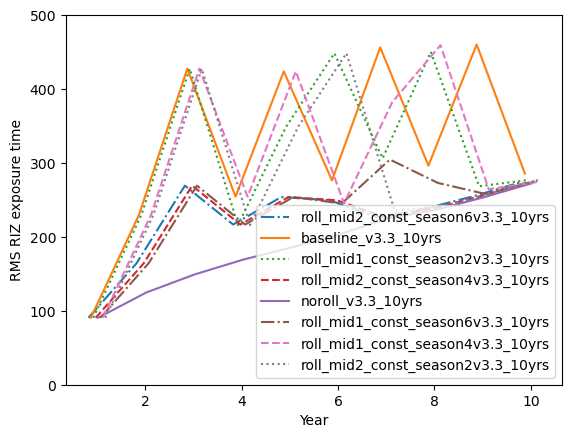

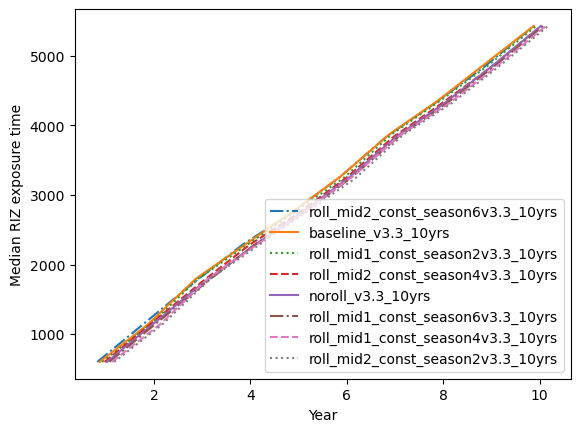

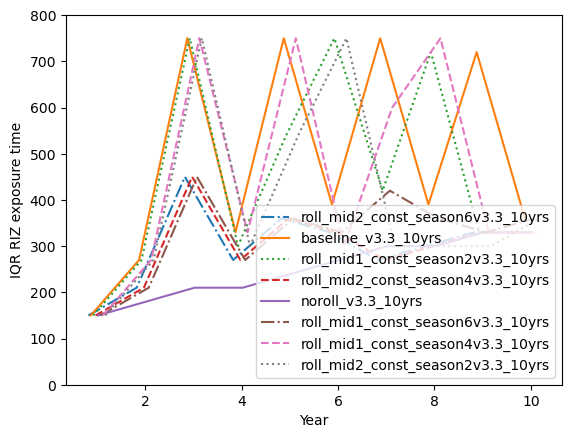

In [56]:
x=np.array(list(set(df2['Year'])))
strategies=list(set(df2['Strategy']))
print(x, strategies)
fig = plt.figure()
ax = fig.add_subplot(111)
offsets = 0.05*np.arange(0,len(strategies))
offsets -= np.mean(offsets)
offset_index = 0
for s in strategies:
    y1=np.array(df2['Std RIZ exposure time'][df['Strategy']==s])
    if 'season2' in s: my_linestyle = 'dotted'
    elif 'season4' in s: my_linestyle = 'dashed'
    elif 'season6' in s: my_linestyle = 'dashdot'
    else: my_linestyle = 'solid'
    ax.plot(x+offsets[offset_index], y1, label=s, linestyle=my_linestyle)
    offset_index += 1
plt.xlabel('Year')
plt.ylabel('RMS RIZ exposure time')
plt.ylim([0,500])
plt.legend(loc='lower right')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
offset_index = 0
for s in strategies:
    y2=np.array(df2['Median RIZ exposure time'][df['Strategy']==s])
    if 'season2' in s: my_linestyle = 'dotted'
    elif 'season4' in s: my_linestyle = 'dashed'
    elif 'season6' in s: my_linestyle = 'dashdot'
    else: my_linestyle = 'solid'
    ax.plot(x+offsets[offset_index], y2, label=s, linestyle=my_linestyle)
    offset_index += 1
plt.xlabel('Year')
plt.ylabel('Median RIZ exposure time')
plt.legend(loc='lower right')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
offset_index = 0
for s in strategies:
    y3=np.array(df2['IQR RIZ exposure time'][df['Strategy']==s])
    if 'season2' in s: my_linestyle = 'dotted'
    elif 'season4' in s: my_linestyle = 'dashed'
    elif 'season6' in s: my_linestyle = 'dashdot'
    else: my_linestyle = 'solid'
    ax.plot(x+offsets[offset_index], y3, label=s, linestyle=my_linestyle)
    offset_index += 1
plt.xlabel('Year')
plt.ylim([0,800])
plt.ylabel('IQR RIZ exposure time')
plt.legend(loc='lower right')
plt.show()


### What if we want to change the opsim we are using?
We define a new opsim file name and then regenerate the metric on this new opsim

No roll v3.3 will be read from /pscratch/sd/r/rhlozek/rubin_sim_data/noroll/noroll_v3.3_10yrs.db
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Bundle diagnostics No roll v3.3 ExgalM5 i and note not like DD% and note not like twilight_neo HealpixSubsetSlicer


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


,Median,Mean,Rms
No_roll_v3_3_ExgalM5_i_and_note_not_like_DD_and_note_not_like_twilight_neo_HEAL,26.4203,26.391543,0.157775


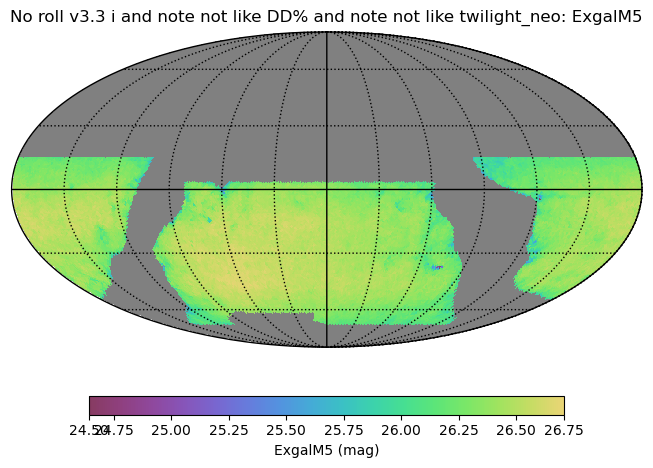

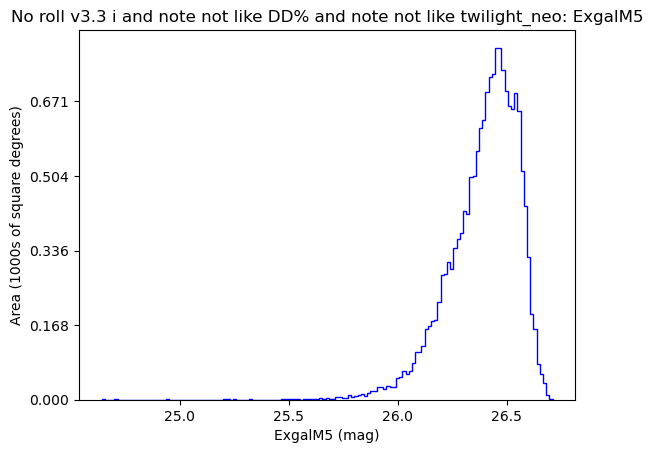

In [263]:
# This lives in Renee's space and she has hacked permissions so the rest of us can read it.  
# But Heather is going to make these accessible in a more sound way.  We'll make and show the same plots for this new strategy.
new_opsim_fname = '/pscratch/sd/r/rhlozek/rubin_sim_data/noroll/noroll_v3.3_10yrs.db'
new_run_name = 'No roll v3.3'
print(f"{new_run_name} will be read from {new_opsim_fname}")
newbgroup, newbd = metric_plots(new_run_name, new_opsim_fname)
newbgroup.plot_all(closefigs=False)
pd.DataFrame([newbd[k].summary_values for k in newbd], index=list(newbd.keys()))

In [290]:
# All together now, just summary stats
sim_list = ['/pscratch/sd/r/rhlozek/rubin_sim_data/sim_baseline/baseline_v3.3_10yrs.db',
           '/pscratch/sd/r/rhlozek/rubin_sim_data/noroll/noroll_v3.3_10yrs.db',
           '/pscratch/sd/r/rhlozek/rubin_sim_data/noroll/roll_mid1_const_season2v3.3_10yrs.db',
           '/pscratch/sd/r/rhlozek/rubin_sim_data/noroll/roll_mid1_const_season4v3.3_10yrs.db',
           '/pscratch/sd/r/rhlozek/rubin_sim_data/noroll/roll_mid1_const_season6v3.3_10yrs.db',
           '/pscratch/sd/r/rhlozek/rubin_sim_data/noroll/roll_mid2_const_season2v3.3_10yrs.db',
           '/pscratch/sd/r/rhlozek/rubin_sim_data/noroll/roll_mid2_const_season4v3.3_10yrs.db',
           '/pscratch/sd/r/rhlozek/rubin_sim_data/noroll/roll_mid2_const_season6v3.3_10yrs.db',]
name_list = [path.splitext(path.basename(sim))[0] for sim in sim_list]
for sim in range(len(name_list)):
    tmpbgroup, tmpbd = metric_plots(name_list[i], sim_list[i])
    print(tmpbd[list(tmpbd.keys())[0]].summary_values)
    #pd.DataFrame([tmpbd[k].summary_values for k in tmpbd], index=list(tmpbd.keys()))    


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Bundle diagnostics baseline_v3.3_10yrs ExgalM5 i and note not like DD% and night < 3653 and note not like twilight_neo HealpixSubsetSlicer
{'Median': 26.398118929020136, 'Mean': 26.36654701955083, 'Rms': 0.15996924818962502}
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Bundle diagnostics baseline_v3.3_10yrs ExgalM5 i and note not like DD% and night < 3653 and note not like twilight_neo HealpixSubsetSlicer
{'Median': 26.398118929020136, 'Mean': 26.36654701955083, 'Rms': 0.15996924818962502}
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Bundle diagnostics baseline_v3.3_10yrs ExgalM5 i and note not like DD% and night < 3653 and note not like twilight_neo HealpixSubsetSlicer
{'Median': 26.398118929020136, 'Mean': 26.36654701955083, 'Rms': 0.15996924818962502}
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Bundle diagnostics baseli

In [291]:
# Define combined plotting routine - base it on Renee's
def combined_metric_plots(use_run_name_vec, use_opsim_fname_vec, 
                          use_metric=maf.ExgalM5(), year=10, use_color_min=None, use_color_max=None):
    # use_run_name_vec says which OpSim DBs we want to use - will also be used for labels
    # use_opsim_fname_vec says where they live, e.g. one item might be `/global/cfs/cdirs/lsst/groups/CO/rubin_sim/sim_baseline/baseline_v2.1_10yrs.db`
    if use_color_min is not None and use_color_max is not None:
        plot_dict={"color_min": use_color_min, "color_max": use_color_max, "x_min": use_color_min, "x_max": use_color_max}
    else:
        plot_dict=None
    days = year*365.3
    constraint_str='filter="i" and note not like "DD%" and night <= XX and note not like "twilight_neo" '
    constraint_str = constraint_str.replace('XX','%d'%days)
    print(constraint_str)
    
    bg_list = []
    bd_list = []
    overall_plot_dict = {}
    color_list = ["k", "r", "b", "c", "g", "o", "m", "y"] # hopefully long enough to handle everything
    for i in range(len(use_run_name_vec)):
        use_run_name = use_run_name_vec[i]
        use_opsim_fname = use_opsim_fname_vec[i]
        print(use_run_name, use_opsim_fname)
        depth_map_bundle = maf.MetricBundle(
            metric=use_metric,
            slicer=maf.HealpixSubsetSlicer(nside=nside, use_cache=False, hpid=np.where(map_labels == "lowdust")[0]),
            constraint=constraint_str,
            run_name=use_run_name,
            summary_metrics=[maf.MedianMetric(), maf.MeanMetric(), maf.RmsMetric()],
            plot_dict=plot_dict
        )
        #print('Bundle diagnostics',depth_map_bundle.run_name, depth_map_bundle.metric.name, 
        #      depth_map_bundle.info_label, depth_map_bundle.slicer.slicer_name, depth_map_bundle.file_root)
        
        bd = maf.metricBundles.make_bundles_dict_from_list([depth_map_bundle])
        print(bd[list(bd.keys())[0]].summary_values)
        #bgroup = maf.MetricBundleGroup(
        #    bd, use_run_name, out_dir="./"
        #)
        #bgroup.run_all()
        
        #bg_list.append(bgroup)
        #bd_list.append(bd)
        #overall_plot_dict[use_run_name] = color_list[i]
    
    #ph = maf.PlotHandler()
    #ph.set_metric_bundles(bg_list)
    #ph.plot(plot_dicts=overall_plot_dict)
    #for i in range(len(bd_list)): print(use_opsim_fname_vec[i], year, bd_list[i][list(bd_list[i].keys())[0]].summary_values)
    #for tmpbd in bd_list: print(tmpbd[list(tmpbd.keys())[0]].summary_values)
 

In [292]:
smaller_sim_list = [sim_list[0], sim_list[1]]
smaller_name_list = [name_list[0], name_list[1]]
#print(sim_list)
#print(name_list)
for year in range(1,3):
    #combined_metric_plots(sim_list, name_list, year=year)
    combined_metric_plots(smaller_name_list, smaller_sim_list, year=year)

filter="i" and note not like "DD%" and night <= 365 and note not like "twilight_neo" 
baseline_v3.3_10yrs /pscratch/sd/r/rhlozek/rubin_sim_data/sim_baseline/baseline_v3.3_10yrs.db
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
None
noroll_v3.3_10yrs /pscratch/sd/r/rhlozek/rubin_sim_data/noroll/noroll_v3.3_10yrs.db
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
None
filter="i" and note not like "DD%" and night <= 730 and note not like "twilight_neo" 
baseline_v3.3_10yrs /pscratch/sd/r/rhlozek/rubin_sim_data/sim_baseline/baseline_v3.3_10yrs.db
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
None
noroll_v3.3_10yrs /pscratch/sd/r/rhlozek/rubin_sim_data/noroll/noroll_v3.3_10yrs.db
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
None
